In [327]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error

In [328]:
df = pd.read_csv('data/serieA_matches.csv')
df_all_matches = pd.read_csv('data/2020_all_matches.csv')

In [329]:
df.shape

(12710, 119)

In [330]:
%%time

home_teams = df_all_matches[['Home', 'Venue']].drop_duplicates().values
team_stadium = {}
for data in home_teams:
     team_stadium[data[0]] = data[1]

CPU times: user 2.92 ms, sys: 0 ns, total: 2.92 ms
Wall time: 2.65 ms


In [331]:
%%time


team_dict = {}
for idx, team in enumerate(df['team'].unique()):
    team_dict[team] = idx

CPU times: user 2.46 ms, sys: 0 ns, total: 2.46 ms
Wall time: 1.73 ms


In [332]:
%%time

df['is_home'] = team_stadium[df['team'].iloc[0]]
df['is_home'] = df['stadium'] == df['is_home']
df['is_home'] = df['is_home'].astype(int)

CPU times: user 3.32 ms, sys: 72 µs, total: 3.39 ms
Wall time: 3.02 ms


In [333]:
cols_types = df.dtypes
cols_types[cols_types == object]

team       object
result     object
stadium    object
state      object
UF         object
date       object
time       object
dtype: object

In [334]:
df.head(2)

,fouls,corners,crosses,touches,tackles,interceptions,aerials_won,clearances,offsides,goal_kicks,...,fouls_drawn_mean_attack,offsides_mean_attack,crosses_mean_attack,tackles_on_mean_attack,interceptions_mean_attack,own_goals_mean_attack,penalty_kicks_won_mean_attack,penalty_kicks_conceded_mean_attack,year,is_home
0,23.0,3.0,11.0,436.0,12.0,5.0,7.0,18.0,2.0,4.0,...,0.0,2.0,1.0,0.0,1.0,0.0,NaN,NaN,2019,0
1,23.0,3.0,11.0,436.0,12.0,5.0,7.0,18.0,2.0,4.0,...,0.0,2.0,1.0,0.0,1.0,0.0,NaN,NaN,2019,0


In [335]:
%%time

# df['date'] = pd.to_datetime(df['date'])
df['time'] = df['time'].apply(lambda time: time.split(':')[0]).astype(int)

CPU times: user 10.7 ms, sys: 59 µs, total: 10.8 ms
Wall time: 9.88 ms


In [336]:
# df['year'] = df['date'].dt.year
# df['month'] = df['date'].dt.month
# df['quarter'] = df['date'].dt.quarter
# df['day'] = df['date'].dt.day

In [337]:
cols_to_remove = [
    'score',
#     "date",
#     'team',
    "stadium",
    "state",
    "UF",
#     "match_id"
]
y_col = 'score'

In [338]:
%%time
df.drop(columns=cols_to_remove, inplace=True)

CPU times: user 8.68 ms, sys: 0 ns, total: 8.68 ms
Wall time: 6.96 ms


In [339]:
%%time
team_dict = {}
for idx, team in enumerate(df['team'].unique()):
    team_dict[team] = idx

CPU times: user 3.67 ms, sys: 0 ns, total: 3.67 ms
Wall time: 3.47 ms


In [340]:
%%time
feature_cols = [col for col in df.columns if col not in cols_to_remove]

CPU times: user 64 µs, sys: 1e+03 ns, total: 65 µs
Wall time: 71.3 µs


In [341]:
%%time

df_home_teams = pd.DataFrame()
df_adversary_teams = pd.DataFrame()

df_teams = pd.DataFrame()
for team in df['team'].unique():
    cols_to_drop = ['is_home', 'team', 'result']
    unique_cols = ['match_id', 'matchweek', 'time', 'year']

    df_team = df[df['team'] == team].copy().reset_index(drop=True)
    df_others_teams = df[
        (df['team'] != team) &
        (df['match_id'].isin(df_team['match_id'].tolist()))
    ].copy().reset_index(drop=True)
    
    columns = [col for col in df_team.columns if col not in cols_to_drop]
    df_team.loc[df_team.index >= 3, columns] = (
        df_team[columns]
        .shift(1)
        .rolling(3)
        .mean()
        .iloc[3:]
    ).copy()

    df_others_teams.loc[df_others_teams.index >= 3, columns] = (
        df_team[columns]
        .shift(1)
        .rolling(3)
        .mean()
        .iloc[3:]
    ).copy()

    df_others_teams.drop(columns=cols_to_drop, inplace=True)
    df_others_teams.columns = [
        col + '_adversary' if col not in unique_cols else col for col in df_others_teams.columns
    ]
    
    
#     df_home_teams = df_home_teams.append(df_team)
#     df_adversary_teams = df_adversary_teams.append(df_others_teams)

    for col in [column for column in df_others_teams.columns if column.endswith('adversary')]:
        df_team[col] = df_others_teams[col]
#     df_teams = df_teams.append(
#         df_team.merge(df_others_teams, on='match_id')
#     )

CPU times: user 6.55 s, sys: 8.28 ms, total: 6.56 s
Wall time: 6.55 s


In [342]:
df_teams = df_team

In [343]:
%%time

# df_home_teams = df_home_teams.append(df_team)
# df_adversary_teams = df_adversary_teams.append(df_others_teams)

# df_teams = df_home_teams.merge(df_adversary_teams, on=unique_cols)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


In [344]:
# 1/0

In [345]:
df_teams = df_teams[~df_teams['team'].isna()].copy()

In [346]:
df_teams['team'] = df_teams['team'].apply(lambda team: team_dict[team])

In [347]:
%%time

result_map = {
    'L': 0,
    'D': 1,
    'W': 3
}

df_teams = df_teams[~df_teams['result'].isna()]
df_teams['result'] = df_teams['result'].apply(lambda result: result_map[result])

CPU times: user 3.87 ms, sys: 0 ns, total: 3.87 ms
Wall time: 3.65 ms


In [348]:
df_teams['result'].fillna(-1, inplace=True)
df_teams = df_teams[df_teams['result'] != -1]
df_teams['result'] = df_teams['result'].astype(int)

In [349]:
df_teams['date'] = pd.to_datetime(df_teams['date'])

df_teams['quarter'] = df_teams['date'].dt.quarter
df_teams['month'] = df_teams['date'].dt.month
df_teams['date'] = df_teams['date'].apply(lambda date: date.weekday())

In [350]:
df_teams.drop(columns=['date', 'date_adversary'], inplace=True)

In [351]:
X = df_teams.drop(columns=['result'])
Y = df_teams['result']

In [352]:
# score
# result

# df.drop(columns=['result'], inplace=True)

In [353]:
# df.drop(columns=cols_to_remove, inplace=True)

In [354]:
# df

In [355]:
# model = XGBClassifier()

# rfe = RFE(model, 25)
# fit = rfe.fit(X, Y)
# print("Num Features: %d" % fit.n_features_)
# print("Selected Features: %s" % fit.support_)
# print("Feature Ranking: %s" % fit.ranking_)

In [356]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_classif

# test = SelectKBest(score_func=f_classif, k=25)
# fit = test.fit(X, Y)
# # summarize scores
# print(fit.scores_)
# features = fit.transform(X)

In [357]:
# cols = np.array(np.array(X.columns.tolist()))[list(fit.support_)]

In [358]:
# X = X[cols]

In [359]:
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=7)

In [360]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    difference = list(np.abs((y_true - y_pred) / y_true))
    difference = [diff if diff != np.inf and not pd.isnull(diff) else 0 for diff in difference]
    return np.mean(difference)


In [361]:
X.sort_values(['matchweek', 'team'], inplace=True)

In [362]:
%%time
# # n_cols_list = [5, 15, 25, 35, 45, 50, 63, 72, 84, 90, 100]
# # for n_cols in n_cols_list:
n_cols = 80

model = XGBClassifier()

rfe = RFE(model, n_cols)
fit = rfe.fit(X.iloc[:1000], Y.iloc[:1000])

cols = np.array(np.array(X.columns.tolist()))[list(fit.support_)]
X_new = X[cols]


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass n_features_to_select=80 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


CPU times: user 2min 11s, sys: 593 ms, total: 2min 11s
Wall time: 34.7 s


In [363]:
# X_new = X
X_train, X_test, y_train, y_test = train_test_split(X_new, Y, test_size=0.1, random_state=7)

In [364]:
# %%time
# parameters = {
#     'eta': [0.05, 0.1, 0.3],
#     'max_depth': [5, 6, 9, 12, 20],
#     'subsample': [0.7, 0.6, 0.8, 1.0],
#     'colsample_bytree': [0.3, 0.6, 0.8, 1.0],
#     'min_child_weight': [1, 5, 8, 10],
#     'gamma': [0.5, 1, 1.5, 2, 5],
#     'n_estimators': [50, 100, 150, 500, 1000]
# }

# clf = GridSearchCV(model, parameters, n_jobs=1, cv=3)

# clf.fit(X_train, y_train)

# best_parameters = clf.best_params_

# model = XGBRegressor(**best_parameters)
model = XGBClassifier()

In [365]:
%%time
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


model.fit(X_train, y_train)

y_pred = list(model.predict(X_test))
predictions = list([round(value) for value in y_pred])

# evaluate predictions
accuracy = mean_absolute_percentage_error(y_test, predictions)
f1 = f1_score(y_test, predictions, average='macro')
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')

print("Accuracy with {} columns: {:.2f}%".format(n_cols, 100 - accuracy * 100.0))
print("Precision with {} columns: {:.2f}".format(n_cols, precision))
print("Recall with {} columns: {:.2f}".format(n_cols, recall))
print("F1 with {} columns: {:.2f}".format(n_cols, f1))


Accuracy with 80 columns: 95.65%
Precision with 80 columns: 0.95
Recall with 80 columns: 0.97
F1 with 80 columns: 0.96
CPU times: user 678 ms, sys: 7.87 ms, total: 686 ms
Wall time: 193 ms


<ipython-input-360-70d46a524b4a>:5: RuntimeWarning: invalid value encountered in true_divide
  difference = list(np.abs((y_true - y_pred) / y_true))


In [366]:
y_test.value_counts()

1    11
3     6
0     6
Name: result, dtype: int64

In [367]:
# param_test1 = {
#  'max_depth':range(3,10,2),
#  'min_child_weight':range(1,6,2)
# }
# gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
#  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
#  param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
# gsearch1.fit(train[predictors],train[target])
# gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

# ==================================================

In [368]:
match_per_round = df['matchweek'].value_counts().to_frame()
last_matchweek = match_per_round[match_per_round > 5].sort_values('matchweek', ascending=False).iloc[0].name

In [369]:
last_match_id = df['match_id'].max()

In [370]:
next_matches = pd.read_csv('data/2020_all_matches.csv')

In [371]:
next_matches['Score'] = next_matches['Score'].fillna('')

In [372]:
next_matches = next_matches[next_matches['Score'] == '']
next_matches['Wk'] = next_matches['Wk'].fillna('')
next_matches = next_matches[next_matches['Wk'] != '']

In [373]:
next_matches = next_matches[next_matches['Wk'] > last_matchweek]

In [374]:
def make_dataset(interested_team, other_team, cols):
    cols_to_use = [col for col in interested_team.columns if 'adversary' not in col]
    
    interested_team = interested_team[cols_to_use]
    other_team = other_team[cols_to_use]
    
    other_team.columns = [col + '_adversary' if col not in ['result', 'match_id'] else col for col in interested_team.columns ]
    
    df = interested_team.merge(other_team, on='match_id')

    return df[cols]
    

In [379]:
predictions = pd.DataFrame()

In [375]:
problem_teams = []
for next_match in next_matches.iterrows():
    try:
        next_match = next_match[1].to_frame().transpose()
        team1, team2 = next_match[['Home', 'Away']].iloc[0]
        date = pd.to_datetime(next_match['Date'].iloc[0])
        time = next_match['Time'].iloc[0].split(':')[0]
        matchweek = int(next_match['Wk'].iloc[0])

        if team1 not in team_dict.keys():
            team_dict[team1] = max(team_dict.values()) + 1

        if team2 not in team_dict.keys():
            team_dict[team2] = max(team_dict.values()) + 1


        if matchweek >= last_matchweek + 1:

            cols = X_new.columns.tolist()
            mean_features_team1 = df[df['team'] == team1].copy()  # [cols]
            mean_features_team2 = df[df['team'] == team2].copy()  # [cols]
            
            if mean_features_team1.shape[0] == 0:
                print(team1)
            
            if mean_features_team2.shape[0] == 0:
                print(team2)
            mean_features_team1['match_id'] = last_match_id + 1
            mean_features_team2['match_id'] = last_match_id + 1

        #     for col in cols:
        #         mean_features_team1[col] = mean_features_team1[col].shift(1).rolling(window=3).mean().copy()
        #         mean_features_team2[col] = mean_features_team2[col].shift(1).rolling(window=3).mean().copy()

            for col in df.columns:
                if df[col].dtype != object and col not in ['score', 'match_id']:
                    mean_features_team1[col] = mean_features_team1[col].shift(1).rolling(window=3).mean().copy()
                    mean_features_team2[col] = mean_features_team2[col].shift(1).rolling(window=3).mean().copy()

            mean_features_team1 = mean_features_team1.iloc[-1:].copy()
            mean_features_team2 = mean_features_team2.iloc[-1:].copy()

            mean_features_team1['is_home'] = 1
            mean_features_team2['is_home'] = 0

            mean_features_team1['team'] = team_dict[team1]
            mean_features_team2['team'] = team_dict[team2]

            dataset_team1 = make_dataset(mean_features_team1, mean_features_team2, cols).round(2)
            dataset_team2 = make_dataset(mean_features_team2, mean_features_team1, cols).round(2)

            game_prediction = dataset_team1.append(dataset_team2)
            prediction = [round(prediction) for prediction in list(model.predict(game_prediction))]
        #     print(f"Rodada {matchweek}: {team1} {prediction[0]} x {prediction[1]} {team2}!")
            print(f"Rodada {matchweek}:\n {team1}: {prediction[0]} \n  {team2}: {prediction[1]}\n\n")
            last_match_id += 1
            
    except Exception as e:
#         print(mean_features_team1.shape)
#         print(mean_features_team2.shape)
        pass

Rodada 6:
 Atlético Mineiro: 0 
  Atl Paranaense: 3


Rodada 6:
 Grêmio: 1 
  Goiás: 0


Rodada 15:
 Vasco da Gama: 0 
  Flamengo: 0


Rodada 15:
 Coritiba: 0 
  Fortaleza: 0


Rodada 15:
 Palmeiras: 1 
  São Paulo: 0


Rodada 15:
 Atlético Mineiro: 0 
  Goiás: 3


Rodada 15:
 Fluminense: 1 
  Bahia: 0


Rodada 15:
 Santos: 0 
  Grêmio: 0


Rodada 15:
 Sport Recife: 1 
  Botafogo (RJ): 3


Rodada 15:
 Atl Goianiense: 0 
  Bragantino: 0


Rodada 15:
 Ceará: 1 
  Corinthians: 0


Rodada 15:
 Internacional: 0 
  Atl Paranaense: 1


Rodada 11:
 Flamengo: 0 
  Goiás: 0




In [376]:
team_dict

{'São Paulo': 0,
 'Botafogo (RJ)': 1,
 'Fortaleza': 2,
 'Atl Paranaense': 3,
 'Chapecoense': 4,
 'Internacional': 5,
 'Coritiba': 6,
 'Atlético Mineiro': 7,
 'Avaí': 8,
 'Sport Recife': 9,
 'Ceará': 10,
 'Flamengo': 11,
 'Cruzeiro': 12,
 'Grêmio': 13,
 'Santos': 14,
 'Bragantino': 15,
 'CSA': 16,
 'Fluminense': 17,
 'Vasco da Gama': 18,
 'Corinthians': 19,
 'Bahia': 20,
 'Palmeiras': 21,
 'Goiás': 22,
 'Atl Goianiense': 23}

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

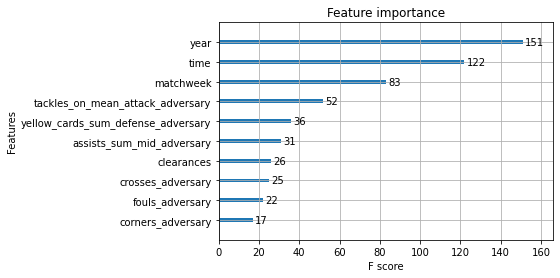

In [377]:
from xgboost import plot_importance
plot_importance(model, max_num_features=10)

In [378]:
df['team'].unique()

array(['São Paulo', 'Botafogo (RJ)', 'Fortaleza', 'Atl Paranaense',
       'Chapecoense', 'Internacional', 'Coritiba', 'Atlético Mineiro',
       'Avaí', 'Sport Recife', 'Ceará', 'Flamengo', 'Cruzeiro', 'Grêmio',
       'Santos', 'Bragantino', 'CSA', 'Fluminense', 'Vasco da Gama',
       'Corinthians', 'Bahia', 'Palmeiras', 'Goiás', 'Atl Goianiense'],
      dtype=object)